In [1]:
#export
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from rl_optimal_search.single_LW_walker import isBetween_c_Vec, isBetween

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Environment

In [3]:
class target_env():
    def __init__(self,
                 Nt = 1000,
                 L = 200,
                 at = 1,
                 ls = 2,
                 agent_step = 1,
                 boundary_condition = 'periodic'):
        
        self.Nt = Nt
        self.L = L
        self.at = at
        self.ls = ls
        self.boundary_condition = boundary_condition
        
        self.init_env()
        
        self.agent_step = agent_step 
        self.current_direction = torch.rand(1)*2*np.pi
        
        self.agent_state = 0
        
    def init_env(self):
        self.target_positions = torch.rand(self.Nt, 2)*self.L
        self.agent_pos = torch.rand(2)*self.L
        self.previous_pos = self.agent_pos.clone()
        
    def update_pos(self, direction):        
            
        # Save previous position to check if crossing happened
        self.previous_pos = self.agent_pos.clone()
            
        self.agent_pos[0] = self.agent_pos[0] + self.agent_step*np.cos(direction)
        self.agent_pos[1] = self.agent_pos[1] + self.agent_step*np.sin(direction)
        
        self.check_bc()
                
    def check_encounter(self):
        encounters = isBetween_c_Vec(self.agent_pos, self.previous_pos, self.target_positions, epsilon = self.at)
        
        if sum(encounters) > 0:   
            distance_previous_pos = np.sqrt((self.agent_pos[0]-self.target_positions[:, 0])**2 + (self.agent_pos[1]-self.target_positions[:, 1])**2)            
            
            # checking which encountered point is closer to previous position
            min_distance_masked = np.argmin(distance_previous_pos[encounters])
            first_encounter = np.arange(self.Nt)[encounters][min_distance_masked]
            
            # If there was encounter, we reset direction and change position of particle to (pos target + ls)
            self.current_direction = np.random.uniform(low = 0, high = 2*np.pi)
            self.agent_pos[0] = self.target_positions[first_encounter, 0] + self.ls*np.cos(self.current_direction)
            self.agent_pos[1] = self.target_positions[first_encounter, 1] + self.ls*np.sin(self.current_direction)
            
            # Update the state of the agent
            self.agent_state = 0
            
            self.check_bc()
            
            return 1
        
        else: return 0
        
    def check_bc(self): 
        if self.boundary_condition == 'reflectant':
            while torch.max(self.agent_pos) > self.L or torch.min(self.agent_pos)< 0: 
                self.agent_pos[self.agent_pos > self.L] = self.agent_pos[self.agent_pos > self.L] - 2*(self.agent_pos[self.agent_pos > self.L] - self.L)
                self.agent_pos[self.agent_pos < 0] = - self.agent_pos[self.agent_pos < 0]


        elif self.boundary_condition == 'periodic':
            while torch.max(self.agent_pos) > self.L or torch.min(self.agent_pos)< 0: 
                self.agent_pos[self.agent_pos > self.L] = self.agent_pos[self.agent_pos > self.L] - self.L
                self.agent_pos[self.agent_pos < 0] = self.L + self.agent_pos[self.agent_pos < 0]  
            
        
    

In [ ]:
env = target_env(Nt = 500, L = 100, boundary_condition = 'reflectant')
T = 1000
pos = torch.zeros(T, 2)
pos[0,:] = env.agent_pos

encountered = []
for t in range(1, T):
    
    if torch.rand(1) > 0.9: action = 1
    else: action = 0
        
    env.update_pos(action)
    touch = env.check_encounter()
    
    if touch is not None:
        try: encountered = torch.vstack((encountered, touch))
        except: encountered = touch
    
    
    pos[t,:] = env.agent_pos
        
    
# encountered = np.array(encountered)

In [ ]:
fig, ax = plt.subplots(figsize = ( 10, 10))
ax.plot(pos[:, 0], pos[:, 1], label = 'Agent Position')
ax.scatter(env.target_positions[:, 0], env.target_positions[:, 1], c = 'C1', marker='.')
ax.scatter(encountered[:, 0], encountered[:, 1], c = 'C2', label = 'Targets encountered')
ax.legend()

# Q-table

In [4]:
class Qtable_constraints:
    
    def __init__(self, state_space,
                 action_space,
                 alpha,
                 gamma, 
                 egreedy,
                 egreedy_decay = 0.999,
                 egreedy_min = 0.1):
        
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.egreedy = egreedy        
        self.egreedy_decay = egreedy_decay
        self.egreedy_min = egreedy_min
        
        self.Q = np.zeros([self.state_space, self.action_space])
        self.V = np.zeros(self.state_space)
        
        
    def act(self, s):
        
        if np.random.rand() < self.egreedy:
            a = np.argmax(np.random.randn(1,self.action_space))            
        else:
            a = np.argmax(self.Q[s,:])
          
        return a
      
    def update_Q(self, s, s1, a, r):        
        #Update Q-Table with new knowledge
        self.Q[s,a] = self.Q[s,a] + self.alpha*(r + self.gamma*np.max(self.Q[s1,:]) - self.Q[s,a])
        
    def update_V(self, s, reward):        
        self.V[s] = self.V[s] + reward

In [5]:
class step_by_step_agent():
    ''' At every time step, the agent decides if it rotates or continues in the current direction'''
    
    def __init__(self, policy, state_space):        
        ''' Class constructor'''
        self.policy = policy
        
        self.current_direction = torch.rand(1)*2*np.pi
        self.agent_state = 0
        
        self.state_space = state_space
        
        
    
    def act(self):
        
        state = np.argwhere((self.state_space - self.agent_state) <= 0)[-1]
        
        action = self.policy.act(state)        
    
        # If the agent changes direction   
        if action == 1:          
            self.current_direction = torch.rand(1)*2*np.pi
            self.agent_state = 0
        
        self.agent_state += 1        
        
        return action, self.current_direction

In [27]:
#%% ---------------------------------------------------------------------------
# Parameters
# -----------------------------------------------------------------------------
episodes = 100
time_ep = 900
# Learning_parameters
learning_rate = 0.01
egreedy = 1
egreedy_decay = 0.999
egreedy_min = 0.1

time_bins = min(time_ep, 1000)
state_space = np.arange(time_bins)#np.linspace(0, time_ep, time_bins)

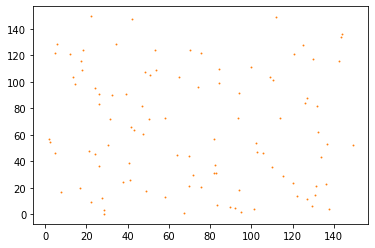

In [43]:
qtable = Qtable_constraints(state_space = time_bins,
                           action_space = 2,
                           alpha = 0.8, 
                           gamma = 0.95, 
                           egreedy= egreedy)

agent = step_by_step_agent(policy = qtable,
                           state_space = state_space)

Nt = 1000
L = 150 
at = 1
Nt = 100

env = target_env(Nt = Nt, L = L, boundary_condition = 'periodic', at = at)
plt.scatter(env.target_positions[:, 0], env.target_positions[:, 1], c = 'C1', marker='.', s = np.pi*env.at**2)

In [53]:
rewards = torch.zeros(episodes, time_ep)
steps = []
step_r = []
pos_agent = np.zeros((episodes, time_ep, 2))

for e in tqdm(range(episodes)):
    
    env.init_env()
    step_length = [1]
    
    for t in (range(time_ep)):
        
        pos_agent[e, t, :] = env.agent_pos.clone()    
        
        
        state = int(np.argwhere((agent.state_space - agent.agent_state) <= 0)[-1])
        
        action, direction = agent.act()
        
        env.update_pos(direction)
        
        
        reward = env.check_encounter()
            
        # Save info
        rewards[e, t] = reward
        
        if reward == 1:
            step_r.append(state)
            agent.agent_state = 0
        
        if action == 0:
            step_length[-1] += 1
        elif action == 1 or reward == 1:
            step_length.append(1)            

        # update q-matrix
        next_state = int(np.argwhere((agent.state_space - agent.agent_state) <= 0)[-1])
        agent.policy.update_Q(state, next_state, action, reward)            
        agent.policy.update_V(next_state, reward) 
        
        if agent.policy.egreedy > egreedy_min:
            agent.policy.egreedy *= egreedy_decay

            
    steps.append(step_length)
    

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Parallel training

In [6]:
from tqdm import tqdm as tqdm_console

def optimal_training(episodes, time_ep, Nt, L, at, ls):
        
    '''  Setting env and agent '''
    time_bins = min(time_ep, 1000)
    state_space = np.arange(time_bins)
    
    env = target_env(Nt = Nt, L = L, at = at, ls = ls)
    
    qtable = Qtable_constraints(state_space = time_bins,
                                action_space = 2,
                                alpha = 0.8, 
                                gamma = 0.95, 
                                egreedy= 1,
                                egreedy_decay = 0.999,
                                egreedy_min = 0.1)    


    agent = step_by_step_agent(policy = qtable,
                               state_space = state_space)
    
    ''' Savers ''' 
    rewards = torch.zeros(episodes, time_ep)
    step_lengths = []
    state_when_rewarded = []
    pos_agent = np.zeros((episodes, time_ep, 2))

    for e in tqdm_console(range(episodes)):

        env.init_env()
        s_length = [1]

        for t in (range(time_ep)):

            pos_agent[e, t, :] = env.agent_pos.clone()    

            state = int(np.argwhere((agent.state_space - agent.agent_state) <= 0)[-1])

            action, direction = agent.act()

            env.update_pos(direction)


            reward = env.check_encounter()

            # Save info
            rewards[e, t] = reward

            if reward == 1:            
                state_when_rewarded.append(state)
                agent.agent_state = 0

            if action == 0:
                s_length[-1] += 1
            elif action == 1 or reward == 1:
                s_length.append(1)            

            # update q-matrix
            next_state = int(np.argwhere((agent.state_space - agent.agent_state) <= 0)[-1])
            agent.policy.update_Q(state, next_state, action, reward)            
            agent.policy.update_V(next_state, reward) 

            if agent.policy.egreedy > agent.policy.egreedy_min:
                agent.policy.egreedy *= agent.policy.egreedy_decay


        step_lengths.append(s_length)
    
    dic_results = {'rewards' : rewards,
                   'step_lengths': np.concatenate(step_lengths),
                   'state_when_rewarded': state_when_rewarded,
                   'Q_matrix': agent.policy.Q}
    
    return dic_results

In [8]:
from joblib import Parallel, delayed

num_ls = 10
lss = np.linspace(0.5, 2.5, num_ls)

L = 150 
at = 1
Nt = 100
episodes = 10000
time_ep = 1000

info = Parallel(n_jobs=num_ls)(delayed (optimal_training) (episodes, time_ep, Nt, L, at, ls)
                           for ls in lss)


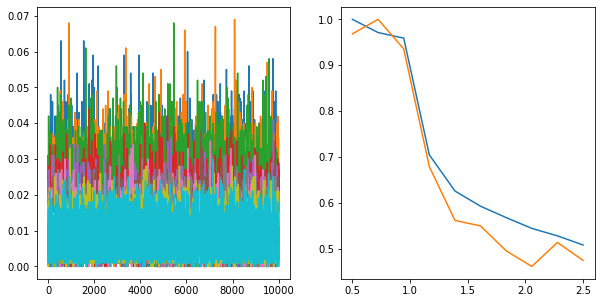

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

late_rew, total_rew = [], []
for info_agent in info:
    
    ax[0].plot(info_agent['rewards'].sum(1)/time_ep);
    total_rew.append(float(info_agent['rewards'].mean()))
    late_rew.append(float(info_agent['rewards'][-100:,:].mean()))

total_rew = np.array(total_rew)
late_rew = np.array(late_rew)

ax[1].plot(lss, total_rew/max(total_rew))
ax[1].plot(lss, late_rew/max(late_rew))

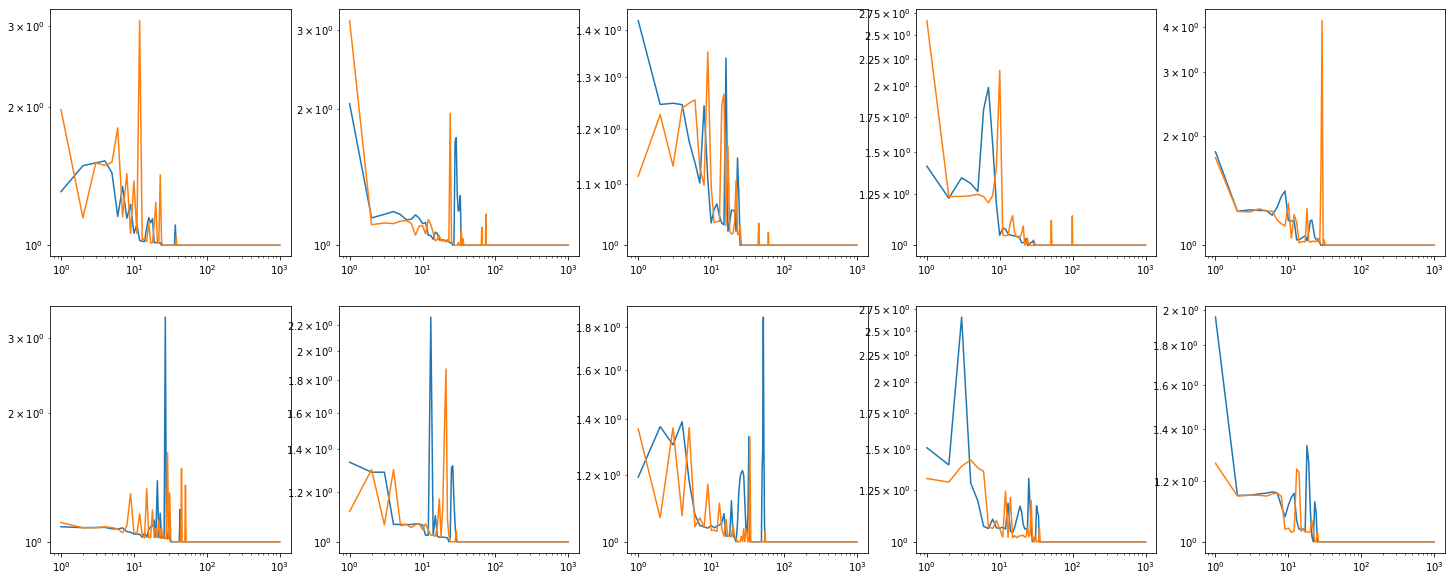

In [12]:
fig, axs = plt.subplots(2, 5, figsize = (25, 10))

for info_agent, ax in zip(info, axs.flatten()):
    ax.loglog(np.arange(1, len(info_agent['Q_matrix'])+1), info_agent['Q_matrix'][:, 0]+1, label = 'stay');
    ax.plot(np.arange(1, len(info_agent['Q_matrix'])+1), info_agent['Q_matrix'][:, 1]+1, label = 'rotate');


In [20]:
time_bins = min(time_ep, 1000)
state_space = np.arange(time_bins)
qtable = Qtable_constraints(state_space = time_bins,
                                action_space = 2,
                                alpha = 0.8, 
                                gamma = 0.95, 
                                egreedy= 1,
                                egreedy_decay = 0.999,
                                egreedy_min = 0.1)    


agent = step_by_step_agent(policy = qtable,
                           state_space = state_space)
agent.policy.egreedy = 0

T = 1000; N = 500

pos = np.zeros((len(lss), N, T, 2))

for idxls, (info_agent, LS) in enumerate(zip(info, lss)):
    
    q = info_agent['Q_matrix'].copy()
    agent.policy.Q = q


    for n in tqdm(range(N)):
        for t in (range(1, T)):

            # trained agent
            _, direction = agent.act()

            pos[idxls, n, t, 0] = pos[idxls, n, t-1, 0] + np.cos(direction)
            pos[idxls, n, t, 1] = pos[idxls, n, t-1, 1] + np.sin(direction)
            
#     msd = (pos[:,:, 0]**2).mean(0)
#     plt.loglog(msd, label = f'ls = {LS}')
            

        

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

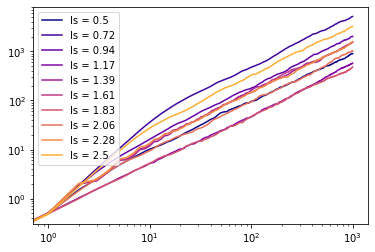

In [25]:
colors=plt.cm.plasma(np.linspace(0,1,len(lss)+2))

for p, c, LS in zip(pos, colors, lss):
    msd = (p[:,:, 0]**2).mean(0)
    plt.loglog(msd, label = f'ls = {np.round(LS, 2)}', c = c)
plt.legend()    

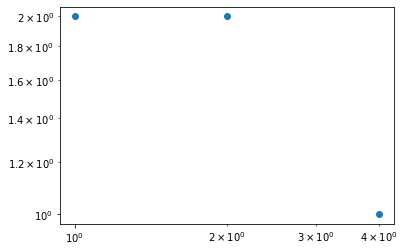

In [50]:
un, c = np.unique(state_when_rewarded, return_counts = True)
plt.loglog(un+1, c, 'o')
# plt.hist(step_r, bins = 100)

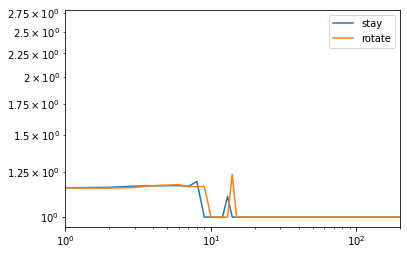

In [51]:
plt.loglog(agent.policy.Q[:, 0]+1, label = 'stay');
plt.plot(agent.policy.Q[:, 1]+1, label = 'rotate');
plt.xlim(1, 200)
plt.legend()

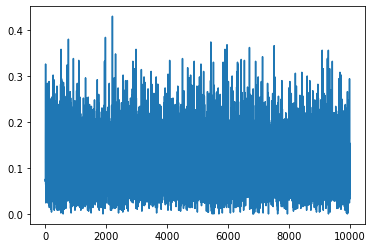

In [198]:
plt.plot(rewards.sum(1)/time_ep);

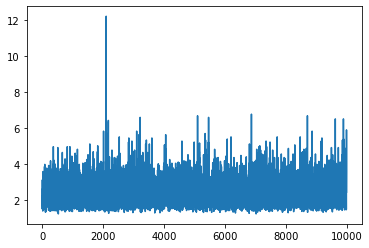

In [187]:
colors=plt.cm.plasma(np.linspace(0,1,len(steps)+5))
m = []
for c, ste in zip(colors, steps):
    bn = np.bincount(ste)[1:]
#     plt.loglog(np.arange(1, len(bn)+1), bn, 'o-', c = c,)
    m.append(np.mean(ste))
# plt.xlim(0.9, 100)

# plt.show()

plt.plot(m)

## Inference trajectory

In [214]:
qtable_rand = Qtable_constraints(state_space = time_bins,
                           action_space = 2,
                           alpha = 0.8, 
                           gamma = 0.95, 
                           egreedy= 1)

agent_rand = step_by_step_agent(policy = qtable_rand,
                           state_space = state_space)


agent.policy.egreedy = 0
T = 1000; N = 500
pos = np.zeros((N, T, 2))
pos_rand = np.zeros((N, T, 2))

for n in tqdm(range(N)):
    for t in (range(1, T)):
        
        # trained agent
        _, direction = agent.act()
            
        pos[n, t, 0] = pos[n, t-1, 0] + np.cos(direction)
        pos[n, t, 1] = pos[n, t-1, 1] + np.sin(direction)
        
        # non-trained
        _, direction_rand = agent_rand.act()
            
        pos_rand[n, t, 0] = pos_rand[n, t-1, 0] + np.cos(direction_rand)
        pos_rand[n, t, 1] = pos_rand[n, t-1, 1] + np.sin(direction_rand)
        

  0%|          | 0/500 [00:00<?, ?it/s]

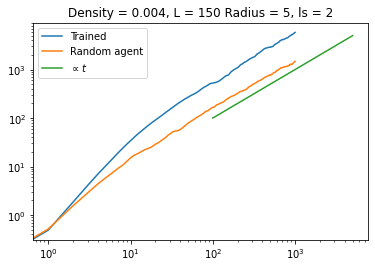

In [216]:
msd = (pos[:,:, 0]**2).mean(0)
msd_rand = (pos_rand[:,:, 0]**2).mean(0)
plt.loglog(msd, label = 'Trained')
plt.loglog(msd_rand, label = 'Random agent')
plt.loglog(np.arange(100, time_ep), np.arange(100, time_ep), label = r'$\propto t$')
plt.title(f'Density = {np.round(Nt/(L**2), 3)}, L = {env.L} Radius = {env.at}, ls = {env.ls}')
plt.legend()

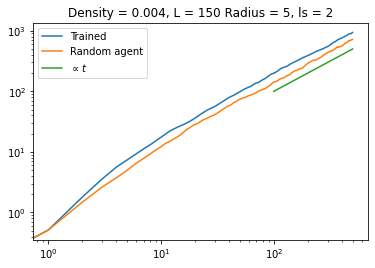

In [200]:
msd = (pos[:,:, 0]**2).mean(0)
msd_rand = (pos_rand[500:,:, 0]**2).mean(0)
plt.loglog(msd, label = 'Trained')
plt.loglog(msd_rand, label = 'Random agent')
plt.loglog(np.arange(100, time_ep), np.arange(100, time_ep), label = r'$\propto t$')
plt.title(f'Density = {np.round(Nt/(L**2), 3)}, L = {env.L} Radius = {env.at}, ls = {env.ls}')
plt.legend()

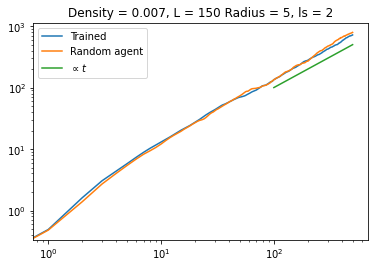

In [193]:
msd = (pos[:,:, 0]**2).mean(0)
msd_rand = (pos_rand[500:,:, 0]**2).mean(0)
plt.loglog(msd, label = 'Trained')
plt.loglog(msd_rand, label = 'Random agent')
plt.loglog(np.arange(100, time_ep), np.arange(100, time_ep), label = r'$\propto t$')
plt.title(f'Density = {np.round(Nt/(L**2), 3)}, L = {env.L} Radius = {env.at}, ls = {env.ls}')
plt.legend()

# Q-Network

In [5]:
class QNAgent:
    def __init__(self, state_size, model, criterion, 
                 optimizer, device, egreedy, egreedy_decay, 
                 egreedy_min, gamma):       
        
        # Input size
        self.state_size = state_size

        # Output size
        self.constraints_size = constraints_size
        self.action_size = self.constraints_size 
        
        
        # Parameters
        self.memory = deque(maxlen=10000)
        self.gamma = gamma    # discount rate
        self.epsilon = egreedy  # exploration rate
        self.epsilon_min = egreedy_min
        self.epsilon_decay = egreedy_decay
        self.model = model   
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
        
    def remember(self, state, action, reward, next_state, done):      
        
        info = [torch.FloatTensor(state).reshape(1, self.state_size).to(self.device), 
                torch.tensor([action], device = self.device), 
                torch.FloatTensor([reward]).to(self.device), 
                torch.FloatTensor(next_state).reshape(1, self.state_size).to(self.device), 
                done]
        self.memory.append(self.Transition(*info))
        
    def act(self, state):        
        state = torch.FloatTensor(state).reshape(1, self.state_size).to(self.device)
        
        if np.random.rand() <= self.epsilon:            
            action = random.randrange(self.constraints_size)                                     
            return action
                
        action = int(torch.argmax(self.model(state)))
        
        return action
    
            
    def replay(self, batch_size):    
        transitions = random.sample(self.memory, batch_size)        
        batch = self.Transition(*zip(*transitions))    
        
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.done)), 
                                      device=self.device, dtype=torch.uint8)        
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                        if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.model(state_batch).gather(1, action_batch.reshape(batch_size, 1))

        next_state_values = reward_batch

        next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()* self.gamma + reward_batch[non_final_mask]        
                
        # Optimize the model
        self.optimizer.zero_grad()
        loss = self.criterion(state_action_values, next_state_values.unsqueeze(1))
        loss.backward()
        self.optimizer.step()    
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 3*state_size)
        self.fc2 = nn.Linear(3*state_size, 2*action_size)
        self.fc3 = nn.Linear(2*action_size, 2*action_size)
        self.fc4 = nn.Linear(2*action_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x